# Table of content
1. [Importing relevent libraries](#01)
2. [Loading Dataset](#02)
3. [Distributions](#03)
    - [Age Distribution](#3.1)
    - [Ethnicity Distribution](#3.2)
    - [Gender Distribution](#3.3)
    - [Gender Distribution](#3.3)
    - [Sample Images](#3.4)
4. [Model for Gender Prediction](#04)
    - [Spliting data into train/test](#4.1)
    - [Build and train model](#4.2)
    - [Evaluating training history](#4.3)
5. [Model for Ethnicity Prediction](#05)
    - [Spliting data into train/test](#5.1)
    - [Build and train model](#5.2)
    - [Evaluating training history](#5.3)
6. [Model for Age Prediction](#06)
    - [Spliting data into train/test](#6.1)
    - [Build and train model](#6.2)
    - [Evaluating training history](#6.3)

## Importing relevent libraries <a id="01"></a>

In [18]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from sklearn.model_selection import train_test_split

## Loading Dataset <a id="02"></a>

In [19]:
# Đọc nhãn từ CSV và chuẩn bị cho việc load ảnh trực tiếp
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


csv_file = 'age_gender_labels_only_FINAL_CLEANED.csv'
image_dir = 'data'

jpg_count = len([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
print(f" Số lượng ảnh .jpg: {jpg_count}")

# Đọc nhãn từ CSV
df_labels = pd.read_csv(csv_file)
print(f" Có {len(df_labels):,} dòng")
print(f" Các cột: {list(df_labels.columns)}")

# Kiểm tra ảnh có tồn tại không
valid_data = []
missing_count = 0

for idx, row in df_labels.iterrows():
    img_path = os.path.join(image_dir, row['img_name'])
    if os.path.exists(img_path):
        valid_data.append({
            'filename': row['img_name'],
            'age': row['age'],
            'gender': row['gender'],
            'ethnicity': row['ethnicity'],
            'filepath': img_path
        })

# Tạo DataFrame với data hợp lệ  
data = pd.DataFrame(valid_data)
print(f" Tìm thấy {len(data)} ảnh hợp lệ")

# Thống kê
print(f" Tổng samples: {len(data)}")
print(f" Age range: {data['age'].min()} - {data['age'].max()}")
print(f" Gender distribution:")
print(f"   - Male (0): {(data['gender']==0).sum()}")
print(f"   - Female (1): {(data['gender']==1).sum()}")
print(f" Ethnicity distribution:")
for eth in sorted(data['ethnicity'].unique()):
    count = (data['ethnicity']==eth).sum()
    print(f"   - Ethnicity {eth}: {count}")

data.head()


 Số lượng ảnh .jpg: 9707
 Có 9,707 dòng
 Các cột: ['age', 'ethnicity', 'gender', 'img_name']
 Tìm thấy 9707 ảnh hợp lệ
 Tổng samples: 9707
 Age range: 1 - 110
 Gender distribution:
   - Male (0): 4363
   - Female (1): 5344
 Ethnicity distribution:
   - Ethnicity 0: 5217
   - Ethnicity 1: 404
   - Ethnicity 2: 1548
   - Ethnicity 3: 1437
   - Ethnicity 4: 1101


,filename,age,gender,ethnicity,filepath
0,1_0_2_20161219203650636.jpg,1,0,2,data\1_0_2_20161219203650636.jpg
1,1_0_2_20161219222752047.jpg,1,0,2,data\1_0_2_20161219222752047.jpg
2,1_0_2_20161219222832191.jpg,1,0,2,data\1_0_2_20161219222832191.jpg
3,1_0_2_20161220144911423.jpg,1,0,2,data\1_0_2_20161220144911423.jpg
4,1_0_2_20161220144914327.jpg,1,0,2,data\1_0_2_20161220144914327.jpg


 Train set: 7765 samples
 Test set: 1942 samples
 Train generator: 243 batches
 Test generator: 61 batches

 Hiển thị sample images từ generator:


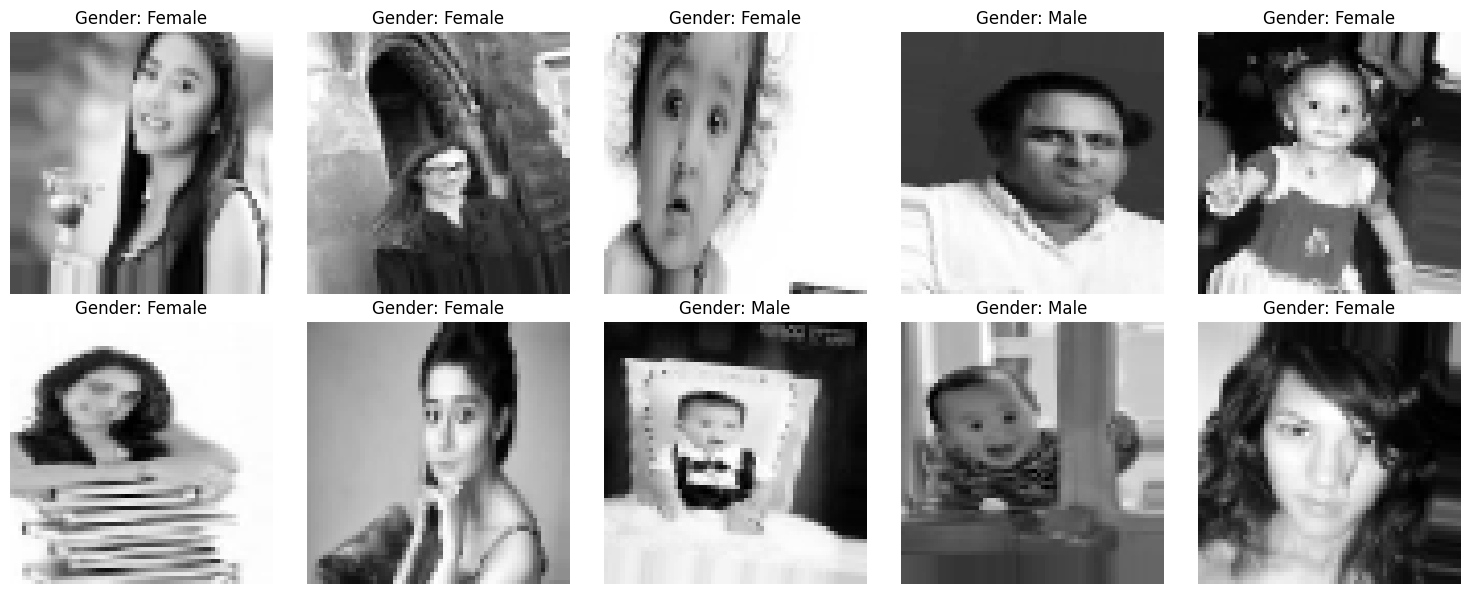


 Dataset summary:
 Age range: 1-110 years (99 unique values)
 Ethnicity categories: 5 unique values
 Gender distribution: {1: 5344, 0: 4363}


In [20]:
# Tạo Data Generators để load ảnh trực tiếp

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Split data thành train/test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42, stratify=data['gender'])
print(f" Train set: {len(train_data)} samples")
print(f" Test set: {len(test_data)} samples")

# Reset index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Custom data generator
class CustomImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size=32, target_size=(64, 64), shuffle=True, augment=False):
        super().__init__()
        self.dataframe = dataframe
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(dataframe))
        self.on_epoch_end()
        
        # Data augmentation
        if augment:
            self.datagen = ImageDataGenerator(
                rotation_range=10,
                width_shift_range=0.1,
                height_shift_range=0.1,
                zoom_range=0.1,
                horizontal_flip=True,
                rescale=1./255
            )
        else:
            self.datagen = ImageDataGenerator(rescale=1./255)
    
    def __len__(self):
        return int(np.ceil(len(self.dataframe) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        return self._generate_batch(batch_indices)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def _generate_batch(self, batch_indices):
        batch_x = np.zeros((len(batch_indices),) + self.target_size + (1,))
        batch_y = np.zeros(len(batch_indices))
        
        for i, idx in enumerate(batch_indices):
            # Load image
            img_path = self.dataframe.iloc[idx]['filepath']
            img = load_img(img_path, target_size=self.target_size, color_mode='grayscale')
            img_array = img_to_array(img)
            
            # Apply augmentation if needed
            if self.augment:
                img_array = self.datagen.random_transform(img_array)
            
            # Normalize
            img_array = img_array / 255.0
            batch_x[i] = img_array
            batch_y[i] = self.dataframe.iloc[idx]['gender']
        
        return batch_x, batch_y

# Tạo generators
train_generator = CustomImageGenerator(
    train_data, 
    batch_size=32, 
    shuffle=True, 
    augment=True  # Data augmentation cho train
)

test_generator = CustomImageGenerator(
    test_data, 
    batch_size=32, 
    shuffle=False, 
    augment=False  # Không augment cho test
)

print(f" Train generator: {len(train_generator)} batches")
print(f" Test generator: {len(test_generator)} batches")

# Hiển thị một batch mẫu
print("\n Hiển thị sample images từ generator:")
sample_x, sample_y = train_generator[0]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    if i < len(sample_x):
        row, col = i // 5, i % 5
        axes[row, col].imshow(sample_x[i].squeeze(), cmap='gray')
        axes[row, col].set_title(f"Gender: {'Male' if sample_y[i]==0 else 'Female'}")
        axes[row, col].axis('off')
    else:
        axes[row, col].axis('off')
plt.tight_layout()
plt.show()

print(f"\n Dataset summary:")
print(f" Age range: {data['age'].min()}-{data['age'].max()} years ({data['age'].nunique()} unique values)")
print(f" Ethnicity categories: {data['ethnicity'].nunique()} unique values")
print(f" Gender distribution: {data['gender'].value_counts().to_dict()}")


## Distributions <a id="03"></a>

In [21]:
# Chuẩn bị dữ liệu cho visualization

age_dist = data['age'].value_counts().sort_index()
ethnicity_dist = data['ethnicity'].value_counts()
gender_dist = data['gender'].value_counts().rename(index={0:'Male',1:'Female'})

# Cấu hình plotting
USE_PLOTLY = False 

# Hàm vẽ biểu đồ với fallback cho matplotlib
def ditribution_plot(x, y, name):
    """Vẽ biểu đồ phân phối với plotly hoặc matplotlib"""
    if USE_PLOTLY:
        try:
            fig = go.Figure([go.Bar(x=x, y=y)])
            fig.update_layout(title_text=name)
            fig.show()
        except:
            # Fallback to matplotlib if plotly fails
            plt.figure(figsize=(12, 6))
            plt.bar(x, y)
            plt.title(name)
            plt.xlabel('Categories')
            plt.ylabel('Count')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()
    else:
        plt.figure(figsize=(12, 6))
        plt.bar(x, y)
        plt.title(name)
        plt.xlabel('Categories')
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Hàm vẽ biểu đồ training history
def line_plot(history_dict, title='Training History'):
    """Vẽ biểu đồ training history với plotly hoặc matplotlib"""
    if USE_PLOTLY:
        try:
            import plotly.express as px
            fig = px.line(
                history_dict, y=['loss', 'val_loss'],
                labels={'index': 'epoch', 'value': 'loss'},
                title=title)
            fig.show()
        except:
            # Fallback to matplotlib
            plt.figure(figsize=(12, 5))
            epochs = range(1, len(history_dict['loss']) + 1)
            plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
            plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
            plt.title(title)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
    else:
        plt.figure(figsize=(12, 5))
        epochs = range(1, len(history_dict['loss']) + 1)
        plt.plot(epochs, history_dict['loss'], 'b-', label='Training Loss')
        plt.plot(epochs, history_dict['val_loss'], 'r-', label='Validation Loss')
        plt.title(title)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()


### Age Distribtion <a id="3.1"></a>

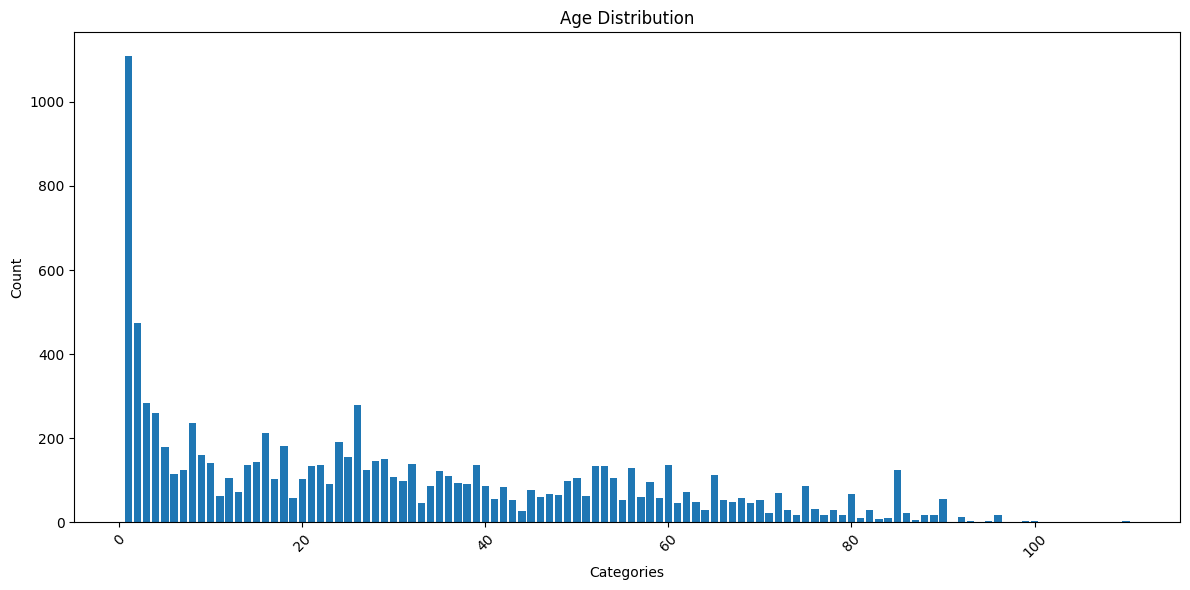

In [22]:
ditribution_plot(x=age_dist.index, y=age_dist.values, name='Age Distribution')

### Ethnicity Distribution <a id="3.2"></a>

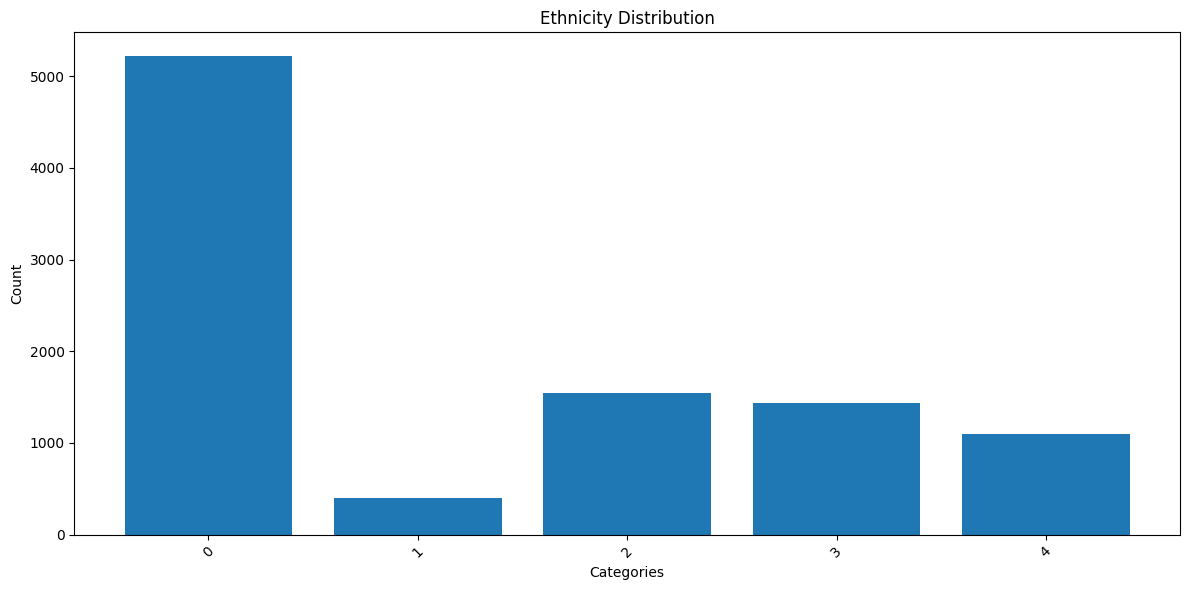

In [23]:
ditribution_plot(x=ethnicity_dist.index, y=ethnicity_dist.values, name='Ethnicity Distribution')

### Gender Distribution <a id="3.3"></a>

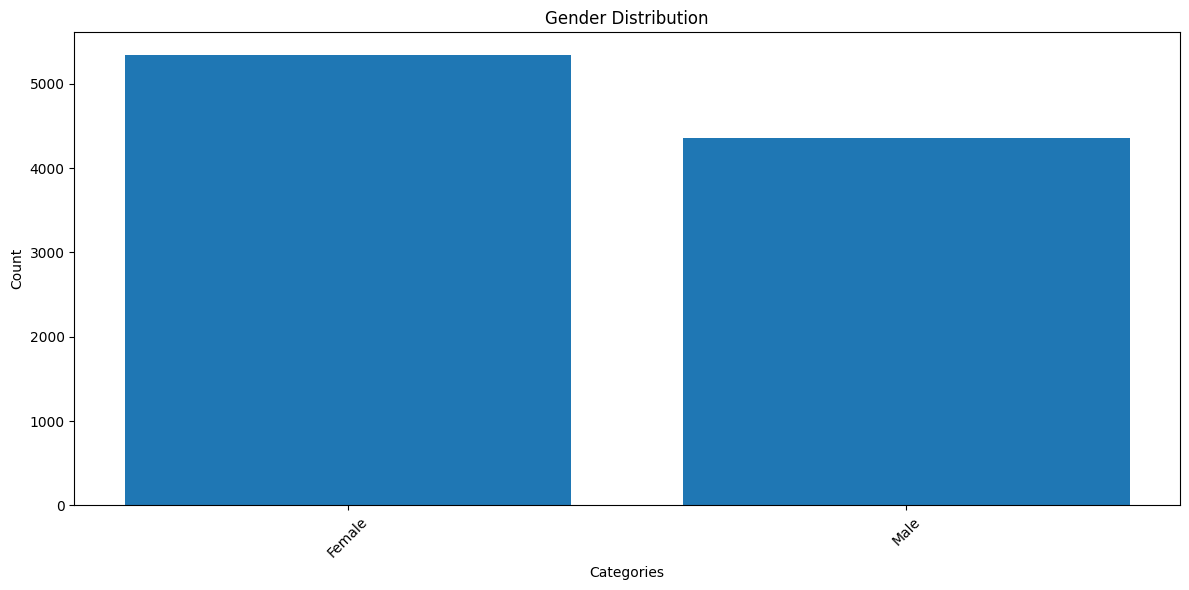

In [24]:
ditribution_plot(x=gender_dist.index, y=gender_dist.values, name='Gender Distribution')

 Hiển thị sample images từ dataset:


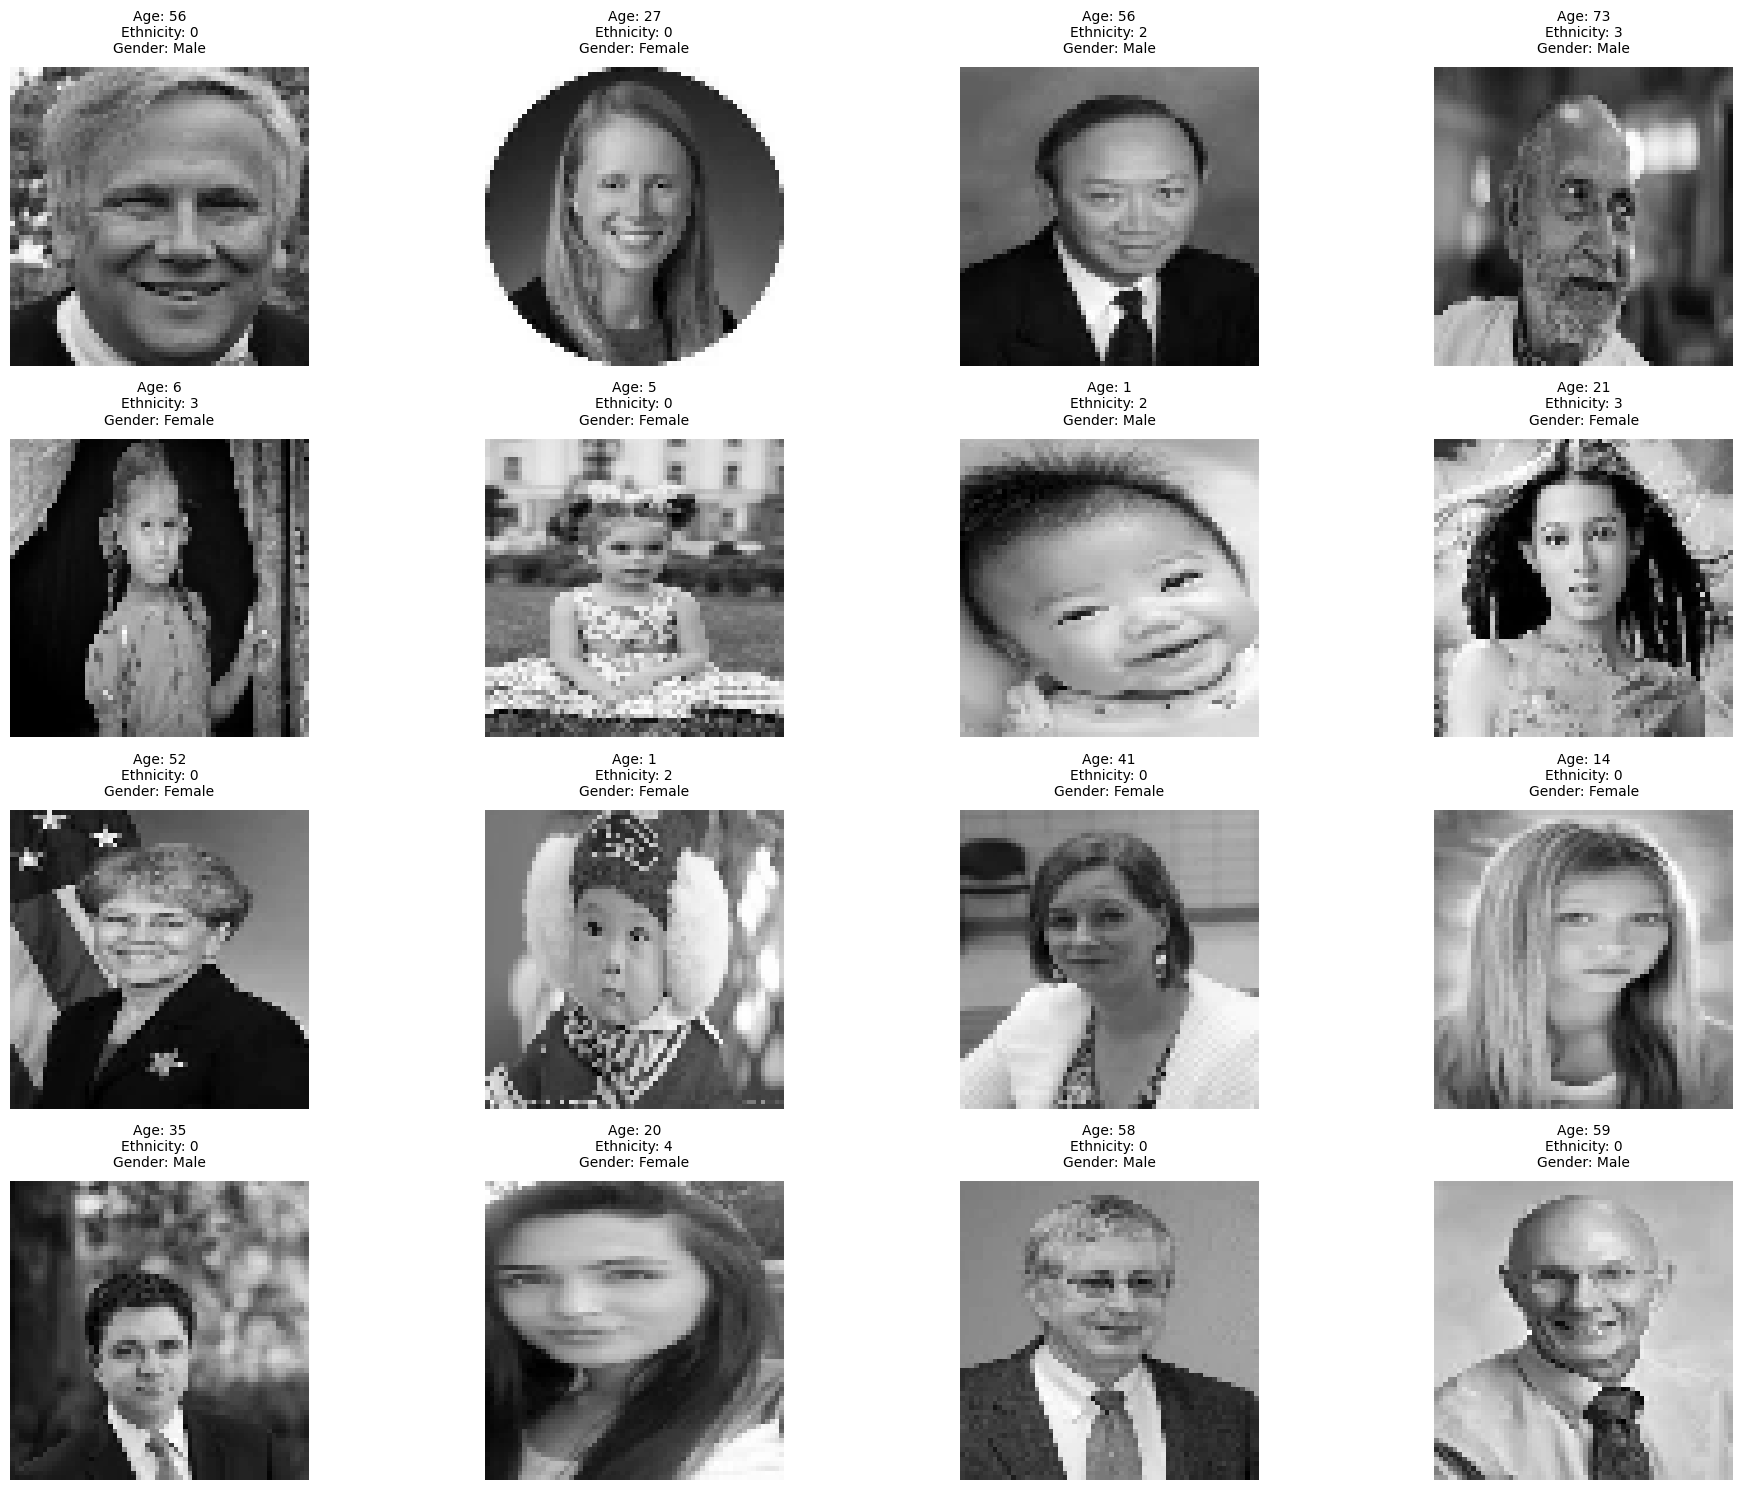

 Tổng số ảnh trong dataset: 9707

 Dataset Summary:
    Age range: 1-110 years
    Gender: {1: 5344, 0: 4363}
    Ethnicity: {0: 5217, 2: 1548, 3: 1437, 4: 1101, 1: 404}


In [25]:
# Hiển thị sample images từ dataset
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

print(" Hiển thị sample images từ dataset:")

sample_indices = np.random.choice(len(data), size=16, replace=False)

plt.figure(figsize=(20, 15))
for i, idx in enumerate(sample_indices):
    plt.subplot(4, 4, i + 1)
    
    # Lấy thông tin từ data
    row = data.iloc[idx]
    img_path = row['filepath']
    
    try:
        # Load và hiển thị ảnh
        img = load_img(img_path, target_size=(64, 64), color_mode='grayscale')
        img_array = img_to_array(img)
        
        plt.imshow(img_array.squeeze(), cmap='gray')
        plt.axis('off')
        
        # Hiển thị thông tin
        gender_text = 'Male' if row['gender'] == 0 else 'Female'
        title = f"Age: {row['age']}\nEthnicity: {row['ethnicity']}\nGender: {gender_text}"
        plt.title(title, fontsize=10, pad=10)
        
    except Exception as e:
        plt.text(0.5, 0.5, f"Error loading\n{row['filename']}", 
                ha='center', va='center', transform=plt.gca().transAxes)
        plt.axis('off')

plt.tight_layout()
plt.show()

print(f" Tổng số ảnh trong dataset: {len(data)}")

# Hiển thị distribution summary ngắn gọn
print(f"\n Dataset Summary:")
print(f"    Age range: {data['age'].min()}-{data['age'].max()} years")
print(f"    Gender: {data['gender'].value_counts().to_dict()}")
print(f"    Ethnicity: {data['ethnicity'].value_counts().to_dict()}")


 <a id="04"></a>

<h1 class="list-group-item active" style='background:purple; border:0'>
    <center>Model for Gender Prediction</center>
</h1>

### Split data into train/test <a id="4.1"></a>

### Build and train model <a id="4.2"></a>

In [26]:
# Xây dựng CNN model cho Gender Prediction

model = tf.keras.Sequential([
    L.Input(shape=(64, 64, 1)),  
    
    # First conv block
    L.Conv2D(32, (3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Dropout(0.25),
    
    # Second conv block  
    L.Conv2D(64, (3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Dropout(0.25),
    
    # Third conv block
    L.Conv2D(128, (3, 3), activation='relu', padding='same'),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Dropout(0.25),
    
    # Dense layers
    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.Dropout(0.5),
    L.Dense(256, activation='relu'),
    L.Dropout(0.5),
    L.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model với optimizer tốt hơn
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


# Callbacks tốt hơn
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=0.0001,
    verbose=1
)

# Model checkpoint để lưu model tốt nhất
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_gender_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

callbacks = [early_stopping, reduce_lr, checkpoint]

# Model summary
model.summary()

print(f"\n Model info:")
print(f"   - Input shape: (64, 64, 1)")
print(f"   - Total parameters: {model.count_params():,}")
print(f"   - Output: Binary classification (0=Male, 1=Female)")
print(f"   - Optimizer: Adam")
print(f"   - Callbacks: Early Stopping, LR Reduction, Model Checkpoint")

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,419,969 (16.86 MB)

 Trainable params: 4,419,521 (16.86 MB)

 Non-trainable params: 448 (1.75 KB)


 Model info:
   - Input shape: (64, 64, 1)
   - Total parameters: 4,419,969
   - Output: Binary classification (0=Male, 1=Female)
   - Optimizer: Adam
   - Callbacks: Early Stopping, LR Reduction, Model Checkpoint


In [27]:
# Train model với Data Generators
print(f" Training batches: {len(train_generator)}")
print(f" Validation batches: {len(test_generator)}")

history = model.fit(
    train_generator,  # Sử dụng train generator
    epochs=30,  # Số epochs phù hợp
    validation_data=test_generator,  # Sử dụng test generator cho validation
    callbacks=callbacks,  # Sử dụng callbacks
    verbose=1
)
print(f"Epoch đã train: {len(history.history['loss'])}")
print(f"Best validation accuracy: {max(history.history['val_accuracy']):.4f}")


 Training batches: 243
 Validation batches: 61
Epoch 1/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.5221 - loss: 2.0579
Epoch 1: val_accuracy improved from -inf to 0.44954, saving model to best_gender_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 43s 169ms/step - accuracy: 0.5222 - loss: 2.0550 - val_accuracy: 0.4495 - val_loss: 1.0564 - learning_rate: 0.0010
Epoch 2/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.5461 - loss: 0.7565
Epoch 2: val_accuracy improved from 0.44954 to 0.48146, saving model to best_gender_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 54s 223ms/step - accuracy: 0.5461 - loss: 0.7564 - val_accuracy: 0.4815 - val_loss: 0.7146 - learning_rate: 0.0010
Epoch 3/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.5696 - loss: 0.6941
Epoch 3: val_accuracy improved from 0.48146 to 0.64470, saving model to best_gender_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 77s 317ms/step - accuracy: 0.5696 - loss: 0.6941 - val_accuracy: 0.6447 - val_loss: 0.6450 - learning_rate: 0.0010
Epoch 4/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.5811 - loss: 0.6767
Epoch 4: val_accuracy did not improve from 0.64470
243/243 ━━━━━━━━━━━━━━━━━━━━ 73s 299ms/step - accuracy: 0.5812 - loss: 0.6767 - val_accuracy: 0.6390 - val_loss: 0.6369 - learning_rate: 0.0010
Epoch 5/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.5990 - loss: 0.6663
Epoch 5: val_accuracy improved from 0.64470 to 0.67920, saving model to best_gender_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.5990 - loss: 0.6662 - val_accuracy: 0.6792 - val_loss: 0.6107 - learning_rate: 0.0010
Epoch 6/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.6206 - loss: 0.6428
Epoch 6: val_accuracy did not improve from 0.67920
243/243 ━━━━━━━━━━━━━━━━━━━━ 88s 362ms/step - accuracy: 0.6206 - loss: 0.6428 - val_accuracy: 0.5644 - val_loss: 0.6705 - learning_rate: 0.0010
Epoch 7/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.6313 - loss: 0.6294
Epoch 7: val_accuracy did not improve from 0.67920
243/243 ━━━━━━━━━━━━━━━━━━━━ 85s 351ms/step - accuracy: 0.6313 - loss: 0.6294 - val_accuracy: 0.6766 - val_loss: 0.6091 - learning_rate: 0.0010
Epoch 8/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6600 - loss: 0.6195
Epoch 8: val_accuracy improved from 0.67920 to 0.68950, saving model to best_gender_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 85s 349ms/step - accuracy: 0.6599 - loss: 0.6195 - val_accuracy: 0.6895 - val_loss: 0.5962 - learning_rate: 0.0010
Epoch 9/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.6655 - loss: 0.6083
Epoch 9: val_accuracy did not improve from 0.68950
243/243 ━━━━━━━━━━━━━━━━━━━━ 79s 323ms/step - accuracy: 0.6655 - loss: 0.6083 - val_accuracy: 0.5984 - val_loss: 0.6242 - learning_rate: 0.0010
Epoch 10/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.6639 - loss: 0.6080
Epoch 10: val_accuracy did not improve from 0.68950
243/243 ━━━━━━━━━━━━━━━━━━━━ 51s 208ms/step - accuracy: 0.6639 - loss: 0.6080 - val_accuracy: 0.6694 - val_loss: 0.5843 - learning_rate: 0.0010
Epoch 11/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.6867 - loss: 0.5773
Epoch 11: val_accuracy improved from 0.68950 to 0.70237, saving model to best_gender_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 84s 345ms/step - accuracy: 0.6866 - loss: 0.5773 - val_accuracy: 0.7024 - val_loss: 0.5624 - learning_rate: 0.0010
Epoch 12/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.6897 - loss: 0.5818
Epoch 12: val_accuracy improved from 0.70237 to 0.71730, saving model to best_gender_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 145s 355ms/step - accuracy: 0.6896 - loss: 0.5818 - val_accuracy: 0.7173 - val_loss: 0.5585 - learning_rate: 0.0010
Epoch 13/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.6930 - loss: 0.5783
Epoch 13: val_accuracy improved from 0.71730 to 0.72606, saving model to best_gender_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 85s 349ms/step - accuracy: 0.6930 - loss: 0.5783 - val_accuracy: 0.7261 - val_loss: 0.5476 - learning_rate: 0.0010
Epoch 14/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.6873 - loss: 0.5830
Epoch 14: val_accuracy did not improve from 0.72606
243/243 ━━━━━━━━━━━━━━━━━━━━ 85s 349ms/step - accuracy: 0.6873 - loss: 0.5830 - val_accuracy: 0.6689 - val_loss: 0.6077 - learning_rate: 0.0010
Epoch 15/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7044 - loss: 0.5620
Epoch 15: val_accuracy did not improve from 0.72606
243/243 ━━━━━━━━━━━━━━━━━━━━ 48s 197ms/step - accuracy: 0.7044 - loss: 0.5620 - val_accuracy: 0.6617 - val_loss: 0.6253 - learning_rate: 0.0010
Epoch 16/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.7091 - loss: 0.5620
Epoch 16: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.

Epoch 16: val_accuracy did not improve from 0.72606
243/243 ━━━━━━━━━━━━━━━━━━━━ 45s 186ms/step - accuracy: 0.7091 - l

243/243 ━━━━━━━━━━━━━━━━━━━━ 42s 175ms/step - accuracy: 0.7153 - loss: 0.5527 - val_accuracy: 0.7297 - val_loss: 0.5142 - learning_rate: 2.0000e-04
Epoch 18/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.7186 - loss: 0.5410
Epoch 18: val_accuracy improved from 0.72966 to 0.73223, saving model to best_gender_model.h5


243/243 ━━━━━━━━━━━━━━━━━━━━ 73s 299ms/step - accuracy: 0.7186 - loss: 0.5410 - val_accuracy: 0.7322 - val_loss: 0.5153 - learning_rate: 2.0000e-04
Epoch 19/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.7355 - loss: 0.5191
Epoch 19: val_accuracy did not improve from 0.73223
243/243 ━━━━━━━━━━━━━━━━━━━━ 85s 349ms/step - accuracy: 0.7355 - loss: 0.5191 - val_accuracy: 0.7075 - val_loss: 0.5353 - learning_rate: 2.0000e-04
Epoch 20/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.7284 - loss: 0.5232
Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001.

Epoch 20: val_accuracy did not improve from 0.73223
243/243 ━━━━━━━━━━━━━━━━━━━━ 85s 351ms/step - accuracy: 0.7284 - loss: 0.5232 - val_accuracy: 0.7085 - val_loss: 0.5596 - learning_rate: 2.0000e-04
Epoch 21/30
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.7305 - loss: 0.5317
Epoch 21: val_accuracy did not improve from 0.73223
243/243 ━━━━━━━━━━━━━━━━━━━━ 84s 345ms/step - accuracy: 0.7305 - loss:

### Evaluate training history <a id="4.3"></a>

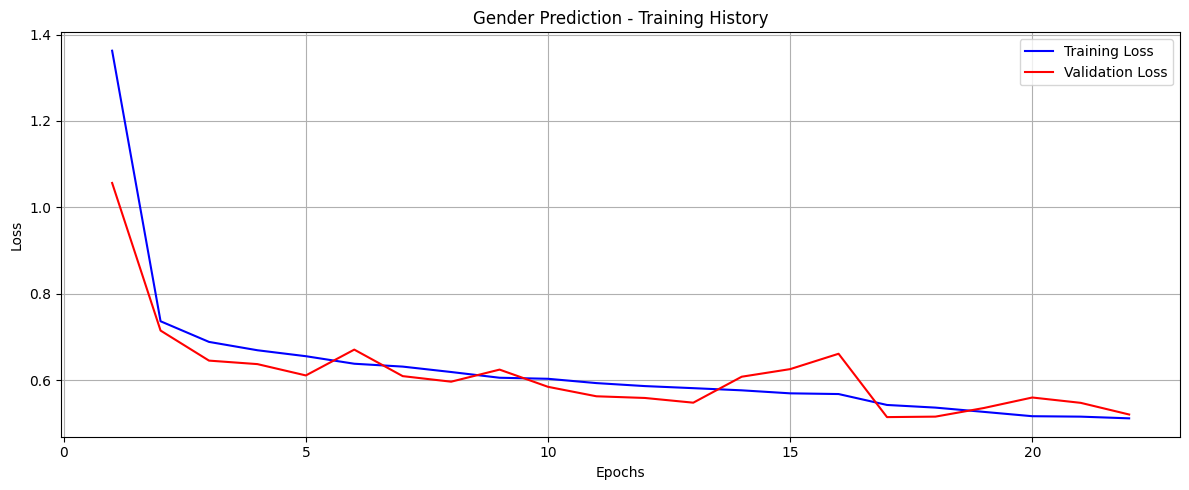

In [28]:
line_plot(history.history, 'Gender Prediction - Training History')

In [29]:
# Evaluate model với test generator
loss, acc = model.evaluate(test_generator, verbose=0)
print(' Test loss: {:.4f}'.format(loss))
print(' Test Accuracy: {:.4f}'.format(acc))

# Thống kê chi tiết
print(f"\n Kết quả chi tiết:")
print(f" Độ chính xác: {acc*100:.2f}%")
print(f" Loss: {loss:.4f}")
print(f" Số samples đánh giá: {len(test_data)}")
print(f" Random baseline: ~50% (binary classification)")

 Test loss: 0.5142
 Test Accuracy: 0.7297

 Kết quả chi tiết:
 Độ chính xác: 72.97%
 Loss: 0.5142
 Số samples đánh giá: 1942
 Random baseline: ~50% (binary classification)


<a id="05"></a>

<h1 class="list-group-item active" style='background:purple; border:0'>
    <center>Model for Ethnicity Prediction</center>
</h1>

### Split data into train/test <a id="5.1"></a>

In [30]:
# Prepare image data array X for traditional ML approach
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

X = []
failed_count = 0

for idx, row in data.iterrows():
    img_path = row['filepath']
    try:
        img = load_img(img_path, target_size=(64, 64), color_mode='grayscale')
        img_array = img_to_array(img) / 255.0  # Normalize về [0,1]
        X.append(img_array)
    except Exception as e:
        print(f" Lỗi loading {img_path}: {e}")
        failed_count += 1

# Chuyển list thành numpy array
X = np.array(X)

print(f" Đã load thành công {len(X)} ảnh")
print(f" Shape của X: {X.shape}")
print(f" Số ảnh lỗi: {failed_count}")



 Đã load thành công 9707 ảnh
 Shape của X: (9707, 64, 64, 1)
 Số ảnh lỗi: 0


In [31]:
y = data['ethnicity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="6.2"></a>

In [32]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(64,64,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(5)
])

model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


## Stop training when validation accuracy reach 79%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.790):
            print("\nReached 79% val_accuracy so cancelling training!")
            self.model.stop_training = True

callback = myCallback()


model.summary()

c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
c:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 822,021 (3.14 MB)

 Trainable params: 822,021 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(
    X_train, y_train, epochs=16, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.5023 - loss: 1.4201 - val_accuracy: 0.5660 - val_loss: 1.1812
Epoch 2/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.5325 - loss: 1.2743 - val_accuracy: 0.5660 - val_loss: 1.1404
Epoch 3/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5457 - loss: 1.2221 - val_accuracy: 0.5752 - val_loss: 1.1122
Epoch 4/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5437 - loss: 1.2036 - val_accuracy: 0.5818 - val_loss: 1.1226
Epoch 5/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.5611 - loss: 1.1428 - val_accuracy: 0.5858 - val_loss: 1.1071
Epoch 6/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.5661 - loss: 1.1382 - val_accuracy: 0.5726 - val_loss: 1.1617
Epoch 7/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5723 - loss: 1.1111 - val_accuracy: 0.5831 - val_loss: 1.0792
Epoch 8/16
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.5816 - loss: 1.0810 - val_accu

### Evaluate training history <a id="5.3"></a>

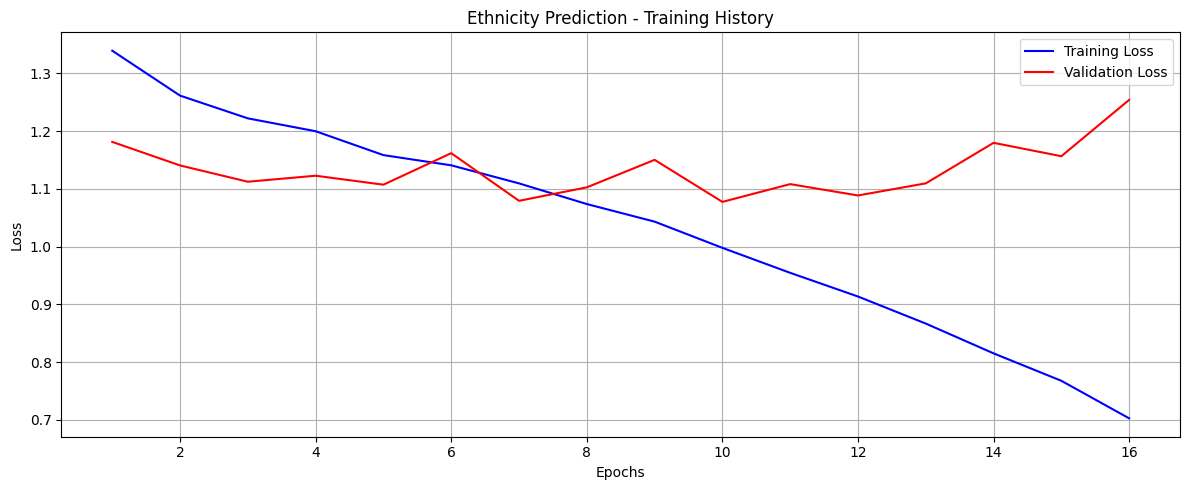

In [34]:
line_plot(history.history, 'Ethnicity Prediction - Training History')

In [35]:
loss, acc = model.evaluate(X_test,y_test,verbose=0)
print('Test loss: {}'.format(loss))
print('Test Accuracy: {}'.format(acc))

Test loss: 1.3963301181793213
Test Accuracy: 0.5716292262077332


<a id="06"></a>

<h1 class="list-group-item active" style='background:orange; border:0'>
    <center>Model for Age prediction</center>
</h1>

### Split data into train/test <a id="6.1"></a>

In [36]:
y = data['age']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.22, random_state=37
)

### Build and train model <a id="6.2"></a>

In [37]:
model = tf.keras.Sequential([
    L.InputLayer(input_shape=(64,64,1)),
    L.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    L.BatchNormalization(),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(64, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Conv2D(128, (3, 3), activation='relu'),
    L.MaxPooling2D((2, 2)),
    L.Flatten(),
    L.Dense(64, activation='relu'),
    L.Dropout(rate=0.5),
    L.Dense(1, activation='relu')
])

sgd = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['mae'])


## Stop training when validation loss reach 110
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_loss')<110):
            print("\nReached 110 val_loss so cancelling training!")
            self.model.stop_training = True

callback = myCallback()


model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │       294,976 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 387,841 (1.48 MB)

 Trainable params: 387,777 (1.48 MB)

 Non-trainable params: 64 (256.00 B)

In [38]:
history = model.fit(
    X_train, y_train, epochs=20, validation_split=0.1, batch_size=64, callbacks=[callback]
)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 737.1403 - mae: 21.0468 - val_loss: 1133.5771 - val_mae: 25.0520
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 589.4155 - mae: 19.1385 - val_loss: 1039.2483 - val_mae: 23.7812
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 513.5100 - mae: 17.7048 - val_loss: 819.3069 - val_mae: 20.8290
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - loss: 480.5849 - mae: 16.8461 - val_loss: 682.6986 - val_mae: 19.0129
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 446.3629 - mae: 16.2566 - val_loss: 555.5460 - val_mae: 17.1676
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - loss: 404.3797 - mae: 15.2853 - val_loss: 505.9556 - val_mae: 16.2934
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 62ms/step - loss: 392.3774 - mae: 14.7999 - val_loss: 363.3264 - val_mae: 14.8329
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 359.1602 - mae: 14.2405 - val_loss: 365.8891 - val_mae: 14.088

### Evaluate training history <a id="6.3"></a>

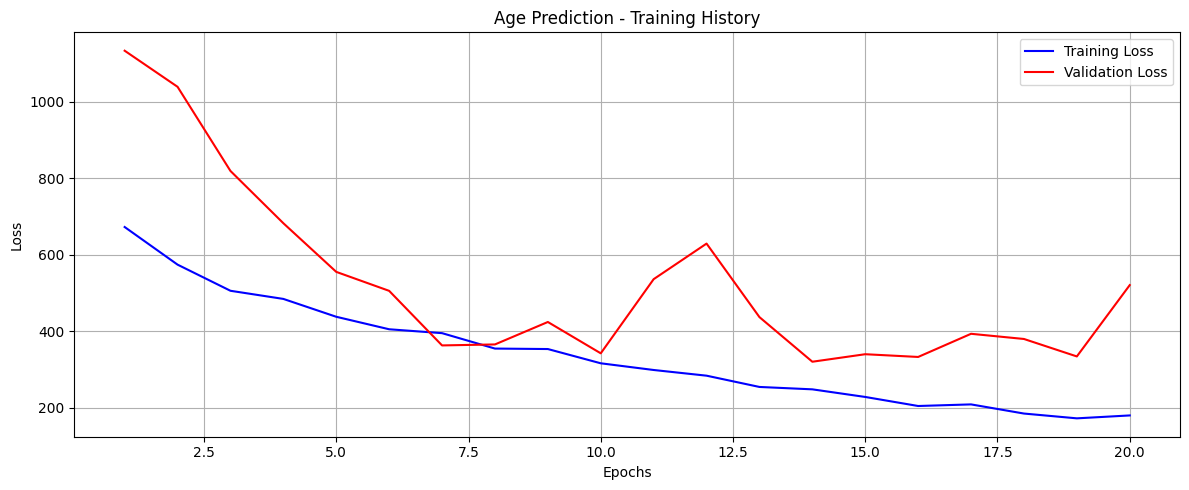

In [39]:
line_plot(history.history, 'Age Prediction - Training History')

In [40]:
mse, mae = model.evaluate(X_test,y_test,verbose=0)
print('Test Mean squared error: {}'.format(mse))
print('Test Mean absolute error: {}'.format(mae))

Test Mean squared error: 531.6516723632812
Test Mean absolute error: 18.095869064331055


![Alt Text](https://www.kudos.com/assets/Blog/b5843aa89b/thankyou__FillWzcwMCw0NDBd.jpg)